In [1]:
import os
import mne
import json
import matplotlib.pyplot as plt
import numpy as np
from mne.datasets import sample
from mne.minimum_norm import apply_inverse, make_inverse_operator, apply_inverse_epochs
from mne.datasets import eegbci, fetch_fsaverage
from tqdm.notebook import tqdm

In [2]:
WORKDIR = os.getcwd()

subject = "fsaverage"
fs_dir = fetch_fsaverage(verbose='ERROR')
subjects_dir = os.path.dirname(fs_dir)
src = os.path.join(fs_dir, "bem", "fsaverage-ico-5-src.fif")
bem = os.path.join(fs_dir, "bem", "fsaverage-5120-5120-5120-bem-sol.fif")
trans = os.path.join(WORKDIR, 'p0-trans.fif')
LABELS = mne.read_labels_from_annot(subject, parc='HCPMMP1', verbose='ERROR')

label_names = [(idx, lab.name) for idx, lab in enumerate(LABELS)]

In [3]:
def make_inverse(epochs, trans, src, bem, plot=False):
    """
    Prepare inverse operator, see https://mne.tools/stable/generated/mne.make_forward_solution.html 
    :param epochs: epoched ERP data
    :param trans: the path to the head<->MRI transform *-trans.fif file produced during coregistration
    :param src: a path to a source space file 
    :param bem: filename of the BEM
    :return: inverse operator
    """
    noise_cov_adhoc = mne.make_ad_hoc_cov(epochs.info)
    noise_cov_adhoc =mne.cov.prepare_noise_cov(noise_cov_adhoc, epochs.info, rank='full', verbose=False)
    # whitener = mne.cov.compute_whitener(noise_cov_adhoc, verbose=False)
    if plot:
        noise_cov_adhoc.plot(epochs.info, verbose=False)
    fwd = mne.make_forward_solution(
        epochs.info, trans=trans, src=src, bem=bem, eeg=True, mindist=5.0, n_jobs=None, verbose=False
    )
    inverse_operator = make_inverse_operator(
            epochs.info, fwd, noise_cov_adhoc, loose=0.2, depth=0.8, verbose=False
        )
    return inverse_operator


def make_stc(epochs, inverse, trans, 
             src, bem, save=False,
             filename=None,
             apply_to_epochs=False):
    """
    Applies inverse operator to epoched data to do source localization
    :param epochs: epoched ERP data
    :param inverse: instance of inverse operator
    :param trans: the path to the head<->MRI transform *-trans.fif file produced during coregistration
    :param src: a path to a source space file 
    :param bem: filename of the BEM
    :param save: whether to save the resulting stc
    :param filename: filename of stc to save
    :param apply_to_epochs: if true, applies to separate epochs, if False - applies to averaged epochs
    :return: stc (surface source estimates)
    """
    method = "dSPM"
    snr = 3
    lambda2 = 1 / snr**2
    if apply_to_epochs:
        stc = apply_inverse_epochs(
            epochs,
            inverse,
            lambda2,
            method=method,
            pick_ori=None,
            verbose=False,
            )
    else:
        stc, residual = apply_inverse(
            epochs.average(),
            inverse,
            lambda2,
            method=method,
            return_residual=True,
            verbose=False,
            )
    if save:
        np.save(os.path.join(WORKDIR, f'p{pID}', 'stc', f'stc_{filename}'), stc)
    return stc


def plot_inverse(cond1, cond2, evoked_1, evoked_2, inverse,
                snr = 3, lambda2_x = 1, contrast=1):
    """
    Makes visualization and compares between two conditions
    :param cond1: condition name
    :param cond2: condition name
    :param evoked_1: ERP data of first condition
    :param evoked_2: ERP data of second condition
    :param inverse: instance of inverse operator
    :param snr: signal-to-noize ratio
    :param lambda2_x: the regularization parameter
    :param contrast: condition contrast
    """
    method = "dSPM"
    snr = snr
    lambda2 = lambda2_x / snr**2
    stc_1, residual_1 = apply_inverse(
            evoked_1,
            inverse,
            lambda2,
            method=method,
            pick_ori=None,
            return_residual=True,
            verbose=False,
        )
    if cond2 is not None:
        stc_2, residual_2 = apply_inverse(
                evoked_2,
                inverse,
                lambda2,
                method=method,
                pick_ori=None,
                return_residual=True,
                verbose=False,
            )

    if contrast == 1:
        stc = stc_1 - stc_2
    elif contrast == -1:
        stc = stc_2 - stc_1
    elif contrast == 0:
        stc = stc_1
    # residual = residual_1_1 - residual_2_1

    fig, ax = plt.subplots()
    ax.plot(1e3 * stc.times, stc.data[::100, :].T)
    ax.set(xlabel="time (ms)", ylabel="%s value" % method)
    fig, axes = plt.subplots()
    evoked_1.plot(axes=axes)
    if evoked_2 is not None:
        evoked_2.plot(axes=axes)
    for text in list(axes.texts):
        text.remove()
    for line in axes.lines:
        line.set_color("#98df81")
    vertno_max, time_max = stc.get_peak(hemi="lh")

    surfer_kwargs = dict(
            hemi="split",
            subjects_dir=subjects_dir,
            surface = 'pial',
            clim=dict(kind="value", lims=[8, 12, 15]),
            views="lateral",
            initial_time=time_max,
            time_unit="s",
            size=(800, 800),
            smoothing_steps=10,
        )
    brain = stc.plot(**surfer_kwargs)
    if contrast != 0:
        brain.add_text(1, 9, f"dSPM {cond1} VS {cond2}", "title", font_size=24)
    else:
        brain.add_text(1, 9, f"dSPM {cond1}", "title", font_size=24)

- Concatenate epoched data of all participants

In [4]:
epochs_all = []
for p_ID in tqdm(range(21), desc='Loading epochs'):
    p_filename = os.path.join(WORKDIR, '..', 'data', 'eeg', f'p{p_ID}_epochs.fif')
    epochs = mne.read_epochs(p_filename, verbose='ERROR')
    epochs.set_eeg_reference(projection=True, verbose='ERROR')
    epochs_all.append(epochs)

conds = list(epochs_all[0].event_id.keys())
Ntimes = epochs_all[0].get_data(copy=False).shape[2]
Nconds = len(epochs_all[0].event_id)
inverse = make_inverse(epochs_all[0], trans, src, bem, plot=False)

my_events = []
epoch_data = []

for ep in tqdm(epochs_all, desc='Extracting epochs data'):
    dat = ep.get_data(copy=True)
    my_events.append(ep.events)
    epoch_data.append(dat)
    
my_events = np.concatenate(my_events)
my_events[:, 0] = np.arange(my_events.shape[0])
my_event_id = epochs_all[0].event_id
epoch_data = np.concatenate(epoch_data)
all_epochs = mne.EpochsArray(data = epoch_data,
                             events=my_events, 
                             event_id=my_event_id, 
                             info=epochs_all[0].info, baseline=(None, 0),
                             tmin=-0.4, verbose='ERROR')    

Loading epochs:   0%|          | 0/21 [00:00<?, ?it/s]

Extracting epochs data:   0%|          | 0/21 [00:00<?, ?it/s]

- Split data by conditions
- Plot averaged ERP across conditions

Projections have already been applied. Setting proj attribute to True.
Projections have already been applied. Setting proj attribute to True.
Projections have already been applied. Setting proj attribute to True.
Projections have already been applied. Setting proj attribute to True.


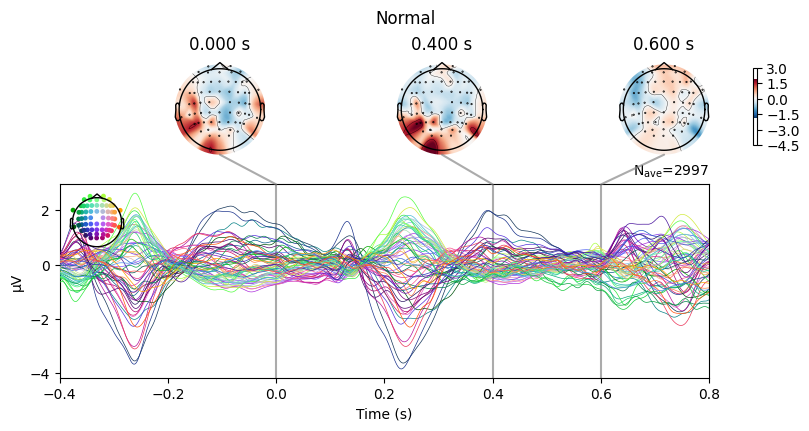

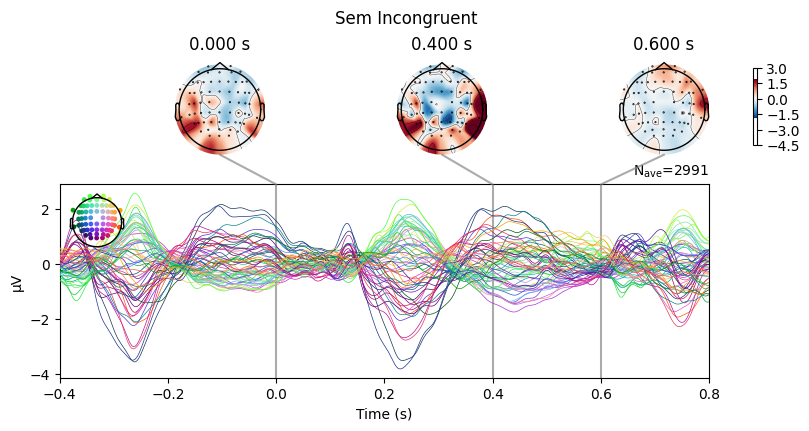

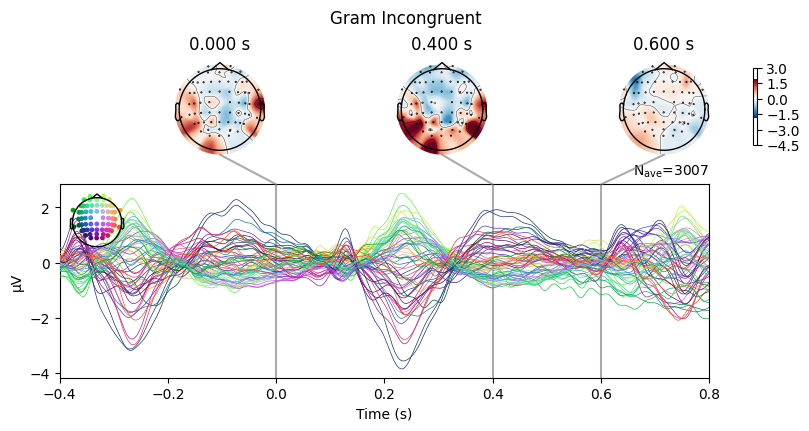

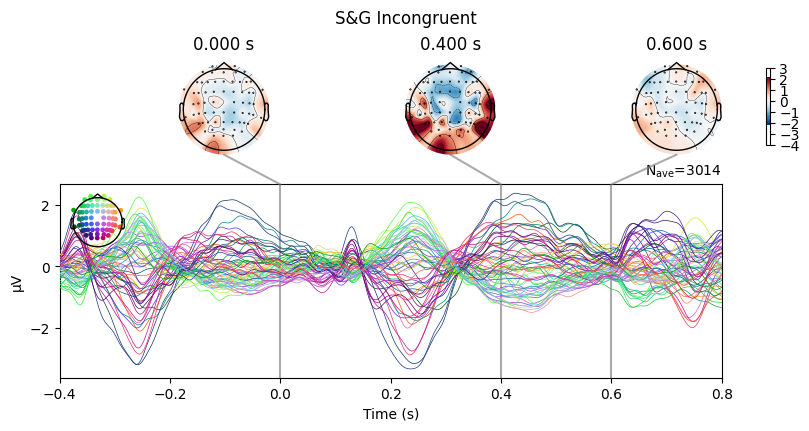

In [5]:
cond_norm = ['Stimulus/S  1_1', 'Stimulus/S  1_2', 'Stimulus/S  1_3'] 
cond_sem = ['Stimulus/S  2_1', 'Stimulus/S  2_2', 'Stimulus/S  2_3']
cond_gram = ['Stimulus/S  3_1', 'Stimulus/S  3_2', 'Stimulus/S  3_3'] 
cond_sg = ['Stimulus/S  4_1', 'Stimulus/S  4_2', 'Stimulus/S  4_3']

evoked_norm = all_epochs[cond_norm].average().pick("eeg")
evoked_sem = all_epochs[cond_sem].average().pick("eeg")
evoked_gram = all_epochs[cond_gram].average().pick("eeg")
evoked_sg = all_epochs[cond_sg].average().pick("eeg")

all_epochs[cond_norm].average().plot_joint(title='Normal', times=[0, 0.4, 0.6], show=False)
all_epochs[cond_sem].average().plot_joint(title='Sem Incongruent', times=[0, 0.4, 0.6], show=False)
all_epochs[cond_gram].average().plot_joint(title='Gram Incongruent', times=[0, 0.4, 0.6], show=False)
all_epochs[cond_sg].average().plot_joint(title='S&G Incongruent', times=[0, 0.4, 0.6], show=False)
plt.show()

- Plot source estimates - difference between two conditions

Using pyvistaqt 3d backend.



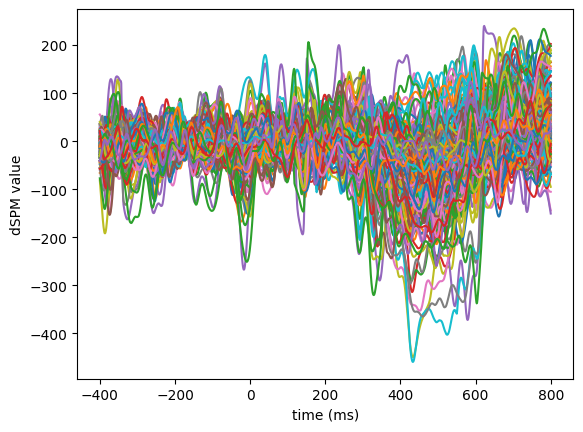

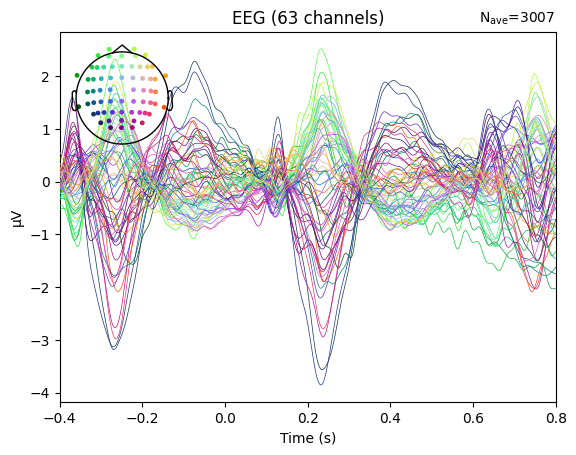

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle



In [6]:
mne.viz.set_3d_backend('pyvistaqt')

plot_inverse('Gram', cond2='Sem', evoked_1=evoked_gram, evoked_2=evoked_sem, inverse=inverse,
             snr = 3, lambda2_x = 1, contrast=1)